# Evolutionary algorithm experiments

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import random

from constants import PATH_PURE_COMPONENTS, PATH_MIXTURES, X
from file_io import load_pickle_file
from fit_with_x_axis_correction.common import *
from fit_with_x_axis_correction.correction_models import *

from numpy.random import normal

logging.basicConfig(level=logging.INFO)

## Load data

In [3]:
pure_components = load_pickle_file(PATH_PURE_COMPONENTS)
mixtures_data = load_pickle_file(PATH_MIXTURES)

## Analysis

### Constants

In [4]:
N_POPULATION = 200
N_SURVIVORS = 30
N_LINEAR_COMBINATIONS = 30
N_MUTATIONS = 100
INIT_GUESS = [0, 0, 0]
INIT_DEVIATIONS = [0.01, 0.1, 1]
N_MAX_GENERATIONS = 300
RSME_THRESHOLD = 2
N_STEADY_THRESHOLD = 50
MAX_X_DEVIATION = 50

In [5]:
correction_model = quadratic_correction
x_original = X
signal = mixtures_data[0]['signal']
true = mixtures_data[0]['contributions']

### Optimization

In [6]:
parameters = []
for _ in range(N_POPULATION):
    candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(INIT_GUESS, INIT_DEVIATIONS)]
    parameters.append(candidate)
parameters = np.array(parameters) 

min_rsme = float(np.inf)
best_solution = None
all_rsme_values = []
counter = 0

In [7]:
for k in range(1, N_MAX_GENERATIONS):
    counter += 1
    rsme_values = []
    
    for candidate in parameters:
        x_target = correction_model(x_original, candidate)
        
        if abs(min(x_target) - min(x_original)) > MAX_X_DEVIATION:
            rsme_values.append(float(np.inf))
            continue
        if abs(max(x_target) - max(x_original)) > MAX_X_DEVIATION:
            rsme_values.append(float(np.inf))
            continue
            
        solution, residual = nnls_fit_with_interpolated_library(x_original, x_target, pure_components, signal)
        rsme_value = rsme(residual)
        rsme_values.append(rsme_value)
        if rsme_value < min_rsme:
            min_rsme = rsme_value
            best_solution = solution
            counter = 0
            print(k, min_rsme, solution)
    
    all_rsme_values.append(rsme_values)
    
    if min_rsme < RSME_THRESHOLD:
        print(f'Target RSME reached. Iteration terminated at round {k}.')
        break
        
    if counter > N_STEADY_THRESHOLD:
        print(f"RSME didn't change in last {N_STEADY_THRESHOLD} rounds. Iteration terminated at round {k}.")
        break
    
    sorted_indices = np.argsort(rsme_values)
    survivors = parameters[sorted_indices][:N_SURVIVORS]
    best_parameters = survivors[0]

    parameters = []
    parameters.append(best_parameters)

    for _ in range(N_LINEAR_COMBINATIONS):
        candidate = [random.choice(column) for column in survivors.T]
        parameters.append(candidate)

    for _ in range(N_MUTATIONS):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(best_parameters, INIT_DEVIATIONS)]
        parameters.append(candidate)

    for _ in range(N_POPULATION - len(parameters)):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(INIT_GUESS, INIT_DEVIATIONS)]
        parameters.append(candidate)
    
    parameters = np.array(parameters)

print('True contributions: ', true)

1 650.4100253969881 [ 19.71979284 178.52580116   0.        ]
1 484.2895778032945 [  9.59482977 327.94386265  98.55373773]
1 442.82182163756585 [ 17.48352916 275.37749534   0.        ]
1 391.71716387500936 [ 19.64909221 303.92093429   0.        ]
1 80.31514978650773 [  8.58141023 336.93863787   3.40411317]
1 64.21912828764397 [ 12.34619899 372.06981999   9.17845046]
1 48.17242638519559 [ 12.71552292 371.92124862   0.        ]
2 43.83274818305772 [  9.05063982 340.80540741  37.22559617]
3 41.59608265804161 [ 11.78043859 365.34706503   0.        ]
4 13.887583150223394 [ 10.26795156 352.17012909  15.72204709]
5 11.550698314910196 [ 11.39702248 353.02384179  18.40199967]
9 10.15941042916688 [ 11.69567408 358.71051309   6.44089794]
11 7.249420357814412 [ 10.73673157 354.10110116  15.85669137]
18 5.137399748710517 [ 11.60689936 357.60467263  10.97959012]
34 5.068569513106019 [ 11.09869118 355.93917283  16.27501069]
38 4.173207727383622 [ 11.12660146 356.02155533  15.52642401]
60 1.81440039767

### Results

C:\Users\ossi\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


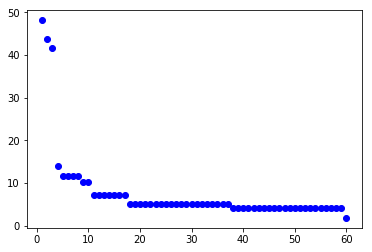

In [8]:
for i, row in enumerate(all_rsme_values,1):
    rsme_min = min(row)
    rsme_stdev = np.std(row)
    rsme_mean = np.mean(row)
    _ = plt.plot(i, rsme_min, 'bo')

## Test refactored version

In [9]:
from fit_with_x_axis_correction.EA import solve_with_EA

In [10]:
solution, parameters = solve_with_EA(x_original,signal,pure_components)

INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 583.5618322474402
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 571.0931032055233
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 548.1300153585282
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 187.22456005038674
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 172.0503899038239
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 148.81561081892312
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 27.87244631311436
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 1, RSME 23.584176271335885
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 2, RSME 15.086493606522284
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 5, RSME 14.065828625254802
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 5, RSME 11.167422937302616
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 